### Task 3

Propose a solution to address the problem. You can implement conditional randomization test (Candès et al. 2018), another existing method, or come up with your own idea.

In [1]:
import random
import numpy as np
#from sklearn.feature_selection import mutual_info_classif

def test_statistic(X, y):
    matrix_multiplication = np.transpose(X) @ y
    #matrix_multiplication = np.matmul(np.transpose(X), y)
    return matrix_multiplication

#def test_statistic(X, y):
#    mi_scores = mutual_info_classif(X, y)
#    return mi_scores



def adjusted_p_value(X, y, test_statistic, j, K):
    X = np.array(X)
    org_X = X.copy()
    summation = []
    for k in range(K):
        for n in range(X.shape[0]):
            possible_samples = np.append(X[n][:j], X[n][j+1:])
            #print(possible_samples.size) == 199
            sample = random.choice(possible_samples)
            X[n][j] = sample

        #print(test_statistic(X, y) > test_statistic(org_X, y))
        summation.append(1 if np.sum(test_statistic(X, y)) > np.sum(test_statistic(org_X, y)) else 0)
        #summation.append(1 if test_statistic(X, y)[j] > test_statistic(org_X, y)[j] else 0)
    adjusted_p_value = 1/(K+1) * (1 + np.sum(summation))

    return adjusted_p_value

In [2]:
from scipy.stats import bernoulli
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import pandas as pd

np.random.seed(21)

# Set the AR coefficient
ar_coefficient = 0.5
p = 200
n = 500
replications = 1000
K = 10

#intercept_p_values = []
#x1_data_p_values = []
p_values = []

# Generate the AR(1) time series
ar_process = ArmaProcess(ar=[1, -ar_coefficient])

# Calculate the p-values for each run
for i in tqdm(range(replications)):

    X = []
    for j in range(n):
        time_series = ar_process.generate_sample(nsample=p)
        X.append(time_series)

    y = bernoulli.rvs(p=0.5, size=n)

    for feature in range(p):
        p_values_adjusted = adjusted_p_value(X, y, test_statistic, feature, K)
        p_values.append(p_values_adjusted)

df = pd.DataFrame({"adjusted p-values": p_values})

df.to_csv("p_values_adj.csv", index=False)

100%|██████████| 1000/1000 [5:35:15<00:00, 20.12s/it]


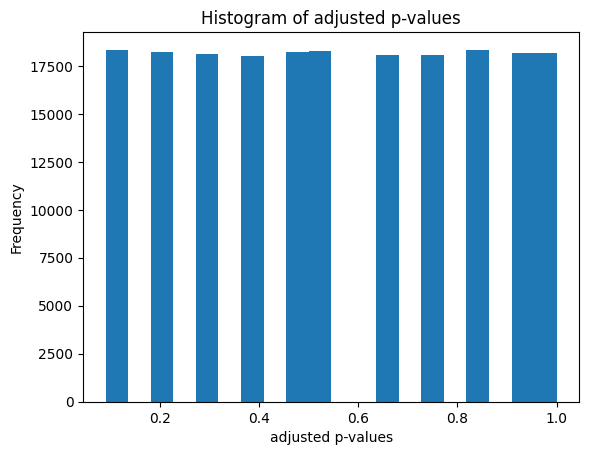

In [3]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(p_values, bins=20) #paper has 20 bins
plt.xlabel('adjusted p-values')
plt.ylabel('Frequency')
plt.title('Histogram of adjusted p-values')
#plt.ylim((0, 2000))
plt.show()